# [Boosters] Raiffeisen Data Cup. Baseline
Общий подход:
- Добавляем к каждой транзакции столбец: is_work (если транзакция находится в пределах 0.02 от дома клиента)
- Добавляем к каждой транзакции столбец: is_home (если транзакция находится в пределах 0.02 от работы клиента)
- Обучаем классификатор предсказывающий вероятность (is_home == 1) для транзакции
- Обучаем классификатор предсказывающий вероятность (is_work == 1) для транзакции

Точность определения местоположения:
- для классификатора is_home: ~3x%
- для классификатора is_work: ~2x%
- общая оценка на Public Leaderboard: ???

Примечание
* Требуется Python версии 3.5
* Требуется библиотека xgboost (для обучения использовалась xgboost версии 0.7.post3)
* Требуются файлы: test_set.csv, train_set.csv в одном каталоге с данным скриптом
* Требования к памяти: должно работать с 2Гб свободного RAM
* Время работы: ~3 минуты (тестировалось на процессоре Intel Core i7-4770)

In [1]:
import pandas as pd
import numpy as np
import datetime

import sklearn.cluster as sk
import xgboost as xgb

import sklearn

from sklearn.model_selection import train_test_split

In [19]:
# Определим типы колонок для экономии памяти
dtypes = {
    'transaction_date': str,
    'atm_address': str,
    'country': str,
    'city': str,
    'amount': np.float32,
    'currency': np.float32,
    'mcc': str,
    'customer_id': str,
    'pos_address': str,
    'atm_address': str,
    'pos_adress_lat': np.float32,
    'pos_adress_lon': np.float32,
    'pos_address_lat': np.float32,
    'pos_address_lon': np.float32,
    'atm_address_lat': np.float32,
    'atm_address_lon': np.float32,
    'home_add_lat': np.float32,
    'home_add_lon': np.float32,
    'work_add_lat': np.float32,
    'work_add_lon': np.float32,
}

# для экономии памяти будем загружать только часть атрибутов транзакций
usecols_train = ['customer_id','transaction_date','amount','country', 'city', 'currency', 'mcc', 'pos_adress_lat', 'pos_adress_lon', 'atm_address_lat', 'atm_address_lon','home_add_lat','home_add_lon','work_add_lat','work_add_lon']
usecols_test = ['customer_id','transaction_date','amount','country', 'city', 'currency', 'mcc', 'pos_address_lat', 'pos_address_lon', 'atm_address_lat', 'atm_address_lon']

## Читаем train_set, test_set, соединяем в один датасет

In [187]:
train = pd.read_csv('data/train_set.csv', dtype = dtypes, usecols = usecols_train)
train.rename(columns = {'pos_adress_lat': 'pos_address_lat', 'pos_adress_lon': 'pos_address_lon'}, inplace = True)

test = pd.read_csv('data/test_set.csv', dtype = dtypes, usecols = usecols_test)
submission = pd.DataFrame(test['customer_id'].unique(), columns = ['_ID_'])

# соединяем test/train в одном DataFrame
train['is_train'] = np.int32(1)
test['is_train'] = np.int32(0)
dt = pd.concat([train, test])

del train, test

In [41]:
test = pd.read_csv('data/test_set.csv', dtype = dtypes, usecols = usecols_test)
test['customer_id'].unique()

array(['00fd410f5c580c8351cafa88d82b60f3',
       '0106b669d5d10148c16ea81890b9d511',
       '01097e0bcfe7e25e3a1e21d53fcde472', ...,
       '6dcb0b69a981bcda27289aa05a801519',
       '6e30f78725b6618176206d875f6a1aae',
       '6f238e23623353aa774eacfae00b55af'], dtype=object)

In [42]:
len(test['customer_id'].unique())

9997

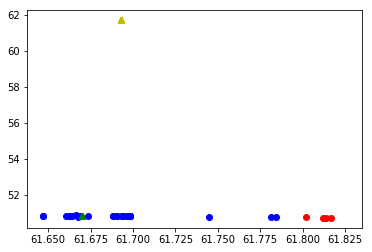

In [175]:
import random
import matplotlib

 
%matplotlib inline

a=train.customer_id.unique()
X_mean= train[(train.customer_id==cust)& (train.pos_address_lat>0) ][[ 'pos_address_lon','pos_address_lat']]
#print len(a)


cust=a[random.randint (0,len(a))]

lon=train[(train.customer_id==cust)& (train.atm_address_lat>0) ][[  'atm_address_lon']]
lat=train[(train.customer_id==cust)& (train.atm_address_lat>0) ][['atm_address_lat' ]]

matplotlib.pyplot.scatter(lat,lon,color='r',alpha=1)

lon=train[(train.customer_id==cust)& (train.pos_address_lat>0) ][ 'pos_address_lon']
lat=train[(train.customer_id==cust)& (train.pos_address_lat>0) ][['pos_address_lat' ]]

X_mean= train[(train.customer_id==cust)& (train.pos_address_lat>0) ][[ 'pos_address_lon','pos_address_lat']]

matplotlib.pyplot.scatter(lat,lon,color='b',alpha=1)


lon=train[(train.customer_id==cust)& (train.work_add_lon>0) ][ 'work_add_lon']
lat=train[(train.customer_id==cust)& (train.work_add_lon>0) ][['work_add_lat' ]]

matplotlib.pyplot.scatter(lat,lon,color='g',alpha=1,marker='^')


lon=train[(train.customer_id==cust)& (train.home_add_lat>0) ][ 'home_add_lat']
lat=train[(train.customer_id==cust)& (train.home_add_lat>0) ][['home_add_lat' ]]

matplotlib.pyplot.scatter(lat,lon,color='y',alpha=1,marker='^')

In [ ]:
a=train.customer_id.unique()
X_mean= train[(train.customer_id==cust)& (train.pos_address_lat>0) ][[ 'pos_address_lon','pos_address_lat']]
ms=sk.MeanShift(bandwidth=0.02)
ms.fit_predict(X_mean)  

In [179]:

ms=sk.MeanShift(bandwidth=0.02)
ms.fit_predict(X_mean)  

array([3, 1, 2, 0, 0, 4, 1, 2, 3, 0, 2, 0, 2, 0, 0, 0, 2, 0, 0, 1, 0, 1,
       0, 0, 0, 0])

In [181]:
np.unique(ms.fit_predict(X_mean), return_counts=True)

(array([0, 1, 2, 3, 4]), array([14,  4,  5,  2,  1]))

### Обрабатываем дату транзакции и категориальные признаки

In [188]:
dt['currency'] = dt['currency'].fillna(-1).astype(np.int32)
dt['mcc'] = dt['mcc'].apply(lambda x: int(x.replace(',', ''))).astype(np.int32)
dt['city'] = dt['city'].factorize()[0].astype(np.int32)
dt['country'] = dt['country'].factorize()[0].astype(np.int32)

# удаляем транзакции без даты
dt.drop(dt[dt['transaction_date'].isnull()].index, axis = 0, inplace = True)
dt['transaction_date'] = dt['transaction_date'].apply(lambda x: datetime.datetime.strptime(x, '%Y-%m-%d'))

### Фичи для даты

In [189]:
dt['weekday'] = dt['transaction_date'].dt.weekday.astype(np.int32)

### Приводим адрес транзакции для pos и atm-транзакций к единообразному виду

In [190]:
dt['is_atm'] = (~dt['atm_address_lat'].isnull()).astype(np.int32)
dt['is_pos'] = (~dt['pos_address_lat'].isnull()).astype(np.int32)

dt['address_lat'] = dt['atm_address_lat'].fillna(0) + dt['pos_address_lat'].fillna(0)
dt['address_lon'] = dt['atm_address_lon'].fillna(0) + dt['pos_address_lon'].fillna(0)

dt.drop(['atm_address_lat','atm_address_lon','pos_address_lat','pos_address_lon'], axis = 1, inplace = True)

# удалим транзакции без адреса
dt.drop(dt[((dt['address_lon'] == 0) & (dt['address_lon'] == 0))].index, axis = 0, inplace = True)

### Генерируем признаки is_home, is_work

In [191]:
lat = dt['home_add_lat'] - dt['address_lat']
lon = dt['home_add_lon'] - dt['address_lon']
dt['is_home'] = (np.sqrt((lat ** 2) + (lon ** 2)) <= 0.02).astype(np.int32)
dt['has_home'] = (~dt['home_add_lon'].isnull()).astype(np.int32)

lat = dt['work_add_lat'] - dt['address_lat']
lon = dt['work_add_lon'] - dt['address_lon']
dt['is_work'] = (np.sqrt((lat ** 2) + (lon ** 2)) <= 0.02).astype(np.int32)
dt['has_work'] = (~dt['work_add_lon'].isnull()).astype(np.int32)

dt.drop(['work_add_lat','work_add_lon','home_add_lat','home_add_lon'], axis = 1, inplace = True)

### Генерируем категориальный признак для адреса

In [192]:
dt['address'] = dt['address_lat'].apply(lambda x: "%.02f" % x) + ';' + dt['address_lon'].apply(lambda x: "%.02f" % x)
dt['address'] = dt['address'].factorize()[0].astype(np.int32)

### Фичи со временем 

In [193]:
a=datetime.datetime(2000, 1, 1)
dt.transaction_date=dt.transaction_date.apply(pd.to_datetime)
dt['weekday'] = dt.transaction_date.apply(lambda x:  x.weekday()  )
dt['days']=dt.transaction_date.apply(lambda x: (x - a).days )
dt['month']=dt.transaction_date.apply(lambda x:  x.month  )

In [ ]:
'weekday','month','days'

### Генерируем несколько абонентских фич

In [194]:
# количество транзакций каждого клиента
dt = dt.merge(dt.groupby('customer_id')['amount'].count().reset_index(name = 'tx'), how = 'left')
dt['tx'] = dt['tx'].astype(np.int32)

dt = dt.merge(dt.groupby(['customer_id','address'])['amount'].count().reset_index(name = 'tx_cust_addr'), how = 'left')
dt['tx_cust_addr'] = dt['tx_cust_addr'].astype(np.int32)

# какая часть транзакций клиента приходится на данный адрес
dt['ratio1'] = dt['tx_cust_addr'] / dt['tx']

In [195]:

dt = dt.merge(dt.groupby(['customer_id'])['amount'].sum().reset_index(name = 'sum_amount'), how = 'left')
dt = dt.merge(dt.groupby(['customer_id','address'])['amount'].sum().reset_index(name = 'sum_amount_address'), how = 'left')

dt['sum_amount_address_ratio1'] = dt['sum_amount_address'] / dt['sum_amount']


dt = dt.merge(dt.groupby(['customer_id','mcc'])['address_lat'].median().reset_index(name = 'mcc_lat'), how = 'left')
dt = dt.merge(dt.groupby(['customer_id','mcc'])['address_lon'].median().reset_index(name = 'mcc_lon'), how = 'left')
dt['mcc_radios']=np.sqrt((dt.address_lat-dt.mcc_lat)**2+(dt.address_lon-dt.mcc_lon)**2)/0.02

dt = dt.merge(dt.groupby(['customer_id','transaction_date'])['amount'].count().reset_index(name = 'transaction_date_cnt'), how = 'left')
dt['transaction_date_cnt_ratio']=dt['transaction_date_cnt']/dt['tx']


dt.drop(['sum_amount','mcc_lat','mcc_lon'], axis = 1, inplace = True)

In [285]:
columns = ['customer_id', 'cluster_n', 'cluster_lon','cluster_lat']
df1 = pd.DataFrame(columns=columns) 

In [1]:
columns = ['customer_id', 'cluster_n', 'cluster_lon','cluster_lat']
df1 = pd.DataFrame(columns=columns) 


a=dt.customer_id.unique()
ms=sk.MeanShift(bandwidth=0.02)
print len(a)
i=0

for cust in a: #a[:20]
    i=i+1
    print i
    if (len(a)-i)%100==0:
        print (len(a)-i)
    
    X_mean= dt[(dt.customer_id==cust)& (dt.address_lat>0) ][[ 'address_lon','address_lat']]
    ms.fit_predict(X_mean) 
    dt.ix[(dt.customer_id==cust)& (dt.address_lat>0), 'cluster_n' ] = ms.predict(X_mean) 
    #print [cust]*len(np.unique(ms.labels_)), np.unique(ms.labels_) ,ms.cluster_centers_[:,0],ms.cluster_centers_[:,1]
     
    d = {'customer_id':[cust]*len(np.unique(ms.labels_)),
         'cluster_n':np.unique(ms.labels_) ,
         'cluster_lon':ms.cluster_centers_[:,0],
         'cluster_lat':ms.cluster_centers_[:,1]
        
        }
    df_tmp = pd.DataFrame(d)
    df1.append(df_tmp)
    #df_tmp = pd.DataFrame(d) 
    
   ## df_cur=df1
    #df1 = pd.concat([df_cur, df_tmp])
     

NameError: name 'pd' is not defined

In [2]:
#dt=pd.read_csv('df.csv')

In [3]:
#df1=pd.read_csv('df1.csv')

In [5]:
a=(dt.address_lat-dt.merge(df1,how='left', on =['cluster_n','customer_id']).cluster_lat)
b=(dt.address_lon-dt.merge(df1,how='left', on =['cluster_n','customer_id']).cluster_lon)

dt['cluster_n_0']=np.sqrt(a**2+b**2)/0.02



In [ ]:
'cluster_n_0','cluster_n'

## Вспомогательные функции для оценки точности классификатора

In [7]:
def _best(x):
    ret = None
    for col in ys:
        pred = ('pred:%s' % col)
        if pred in x:
            i = (x[pred].idxmax())
            cols = [pred,'address_lat','address_lon']
            if col in x:
                cols.append(col)
            tmp = x.loc[i,cols]
            tmp.rename({
                'address_lat':'%s:add_lat' % col,
                'address_lon':'%s:add_lon' % col,
            }, inplace = True)
            if ret is None:
                ret = tmp
            else:
                ret = pd.concat([ret, tmp])
    return ret

In [8]:
def predict_proba(dt, ys = ['is_home', 'is_work']):
    for col in ys:
        pred = ('pred:%s' % col)
        dt[pred] = model[col].predict_proba(dt[xs])[:,1]
    return dt.groupby('customer_id').apply(_best).reset_index()

In [9]:
def score(dt, ys = ['is_home', 'is_work']):
    dt_ret = predict_proba(dt, ys)
    mean = 0.0
    for col in ys:
        col_mean = dt_ret[col].mean()
        mean += col_mean
    if len(ys) == 2:
        mean = mean / len(ys)
    return mean

### Признаки, на которых будем обучать модель

In [10]:
xs = ['amount','currency','city','country','mcc','is_atm','is_pos','ratio1','sum_amount_address','sum_amount_address_ratio1','mcc_radios','transaction_date_cnt'
,'transaction_date_cnt_ratio','weekday','month','days']
ys = ['is_home', 'is_work']

# Создаем классификаторы
**Hint**: можно поигратьcя с гиперпараметрами для лучшего результата :)

In [11]:
model0 = {
    'is_home': xgb.XGBClassifier(n_estimators = 100, n_jobs = 3),
    'is_work': xgb.XGBClassifier(n_estimators = 100, n_jobs = 3),
}

In [12]:
model = {}

# последовательно обучаем два классификатора
for col in ['is_home', 'is_work']:
    
    #выберем для обучение транзакции только тех клиентов из train, у которых хоть в одной транзакции указано место работы/жительства
    cust_train = dt[dt['is_train'] == 1].groupby('customer_id')[col].max()
    cust_train = cust_train[cust_train > 0].index
    print np.shape(cust_train)

(7489,)
(3210,)


# Обучаем классификаторы

In [14]:
model = {}

# последовательно обучаем два классификатора
for col in ['is_home', 'is_work']:
    
    #выберем для обучение транзакции только тех клиентов из train, у которых хоть в одной транзакции указано место работы/жительства
    cust_train = dt[dt['is_train'] == 1].groupby('customer_id')[col].max()
    cust_train = cust_train[cust_train > 0].index
    
    #разобъем train на train/valid для валидации
    cust_train, cust_valid = train_test_split(cust_train, test_size = 0.1, shuffle = True, random_state = 2)
    
    train = pd.DataFrame(cust_train, columns = ['customer_id']).merge(dt, how = 'left')
    valid = pd.DataFrame(cust_valid, columns = ['customer_id']).merge(dt, how = 'left')

    print ("Training:", col)
    clf = sklearn.base.clone(model0[col])
    clf.fit(train[xs], train[col], eval_metric = 'logloss', eval_set = [(train[xs], train[col]), (valid[xs], valid[col])], verbose=10)
    model[col] = clf
    print ("Train accuracy:", score(train, ys = [col]))
    print ("Test accuracy:", score(valid, ys = [col]))
    print ()


('Training:', 'is_home')
[0]	validation_0-logloss:0.659603	validation_1-logloss:0.659681
[10]	validation_0-logloss:0.512707	validation_1-logloss:0.514159
[20]	validation_0-logloss:0.471921	validation_1-logloss:0.474692
[30]	validation_0-logloss:0.456626	validation_1-logloss:0.462815
[40]	validation_0-logloss:0.446508	validation_1-logloss:0.456076
[50]	validation_0-logloss:0.438471	validation_1-logloss:0.452364
[60]	validation_0-logloss:0.43334	validation_1-logloss:0.450032
[70]	validation_0-logloss:0.429719	validation_1-logloss:0.450303
[80]	validation_0-logloss:0.426936	validation_1-logloss:0.449351
[90]	validation_0-logloss:0.424836	validation_1-logloss:0.449332
[99]	validation_0-logloss:0.42317	validation_1-logloss:0.449807
('Train accuracy:', 0.5416913946587537)
('Test accuracy:', 0.5500667556742324)
()
('Training:', 'is_work')
[0]	validation_0-logloss:0.656515	validation_1-logloss:0.656449
[10]	validation_0-logloss:0.496298	validation_1-logloss:0.501573
[20]	validation_0-logloss:0

In [45]:
model = {}

# последовательно обучаем два классификатора
for col in ['is_home', 'is_work']:
    
    #выберем для обучение транзакции только тех клиентов из train, у которых хоть в одной транзакции указано место работы/жительства
    cust_train = dt[dt['is_train'] == 1].groupby('customer_id')[col.replace('is_','has_')].max()
    cust_train = cust_train[cust_train > 0].index
    
    #разобъем train на train/valid для валидации
    cust_train, cust_valid = train_test_split(cust_train, test_size = 0.1, shuffle = True, random_state = 2)
    
    train = pd.DataFrame(cust_train, columns = ['customer_id']).merge(dt, how = 'left')
    valid = pd.DataFrame(cust_valid, columns = ['customer_id']).merge(dt, how = 'left')

    print ("Training:", col)
    clf = sklearn.base.clone(model0[col])
    clf.fit(train[xs], train[col], eval_metric = 'logloss', eval_set = [(train[xs], train[col]), (valid[xs], valid[col])], verbose=10)
    model[col] = clf
    print ("Train accuracy:", score(train, ys = [col]))
    print ("Test accuracy:", score(valid, ys = [col]))
    print ()


('Training:', 'is_home')
[0]	validation_0-logloss:0.658342	validation_1-logloss:0.657099
[10]	validation_0-logloss:0.513842	validation_1-logloss:0.507505
[20]	validation_0-logloss:0.481401	validation_1-logloss:0.474682
[30]	validation_0-logloss:0.47064	validation_1-logloss:0.464442
[40]	validation_0-logloss:0.464078	validation_1-logloss:0.45901
[50]	validation_0-logloss:0.459929	validation_1-logloss:0.456033
[60]	validation_0-logloss:0.456621	validation_1-logloss:0.453878
[70]	validation_0-logloss:0.454026	validation_1-logloss:0.452766
[80]	validation_0-logloss:0.451746	validation_1-logloss:0.452048
[90]	validation_0-logloss:0.449927	validation_1-logloss:0.451534
[99]	validation_0-logloss:0.448292	validation_1-logloss:0.451445
('Train accuracy:', 0.4118888888888889)
('Test accuracy:', 0.407)
()
('Training:', 'is_work')
[0]	validation_0-logloss:0.647191	validation_1-logloss:0.647433
[10]	validation_0-logloss:0.451774	validation_1-logloss:0.452244
[20]	validation_0-logloss:0.409084	valid

# Predict

In [44]:
cust_test = test['customer_id'].unique()
test = pd.DataFrame(cust_test, columns = ['customer_id']).merge(dt, how = 'left')
test = predict_proba(test)
test.rename(columns = {
        'customer_id':'_ID_',
        'is_home:add_lat': '_HOME_LAT_',
        'is_home:add_lon': '_HOME_LON_',
        'is_work:add_lat': '_WORK_LAT_',
        'is_work:add_lon': '_WORK_LON_'}, inplace = True)
test = test[['_ID_', '_WORK_LAT_', '_WORK_LON_', '_HOME_LAT_', '_HOME_LON_']]

In [47]:
len( test['_ID_'].unique())

9997

In [34]:
test.rename(columns = {
        'customer_id':'_ID_',
        'is_home:add_lat': '_HOME_LAT_',
        'is_home:add_lon': '_HOME_LON_',
        'is_work:add_lat': '_WORK_LAT_',
        'is_work:add_lon': '_WORK_LON_'}, inplace = True)

# Формируем submission-файл

In [50]:
submission = pd.DataFrame(test['_ID_'].unique(), columns = ['_ID_'])
# Заполняем пропуски
submission = submission.merge(test, how = 'left').fillna(0)

sample = pd.read_csv('data/sample.csv')

submission.columns = sample.columns


# Пишем файл submission
submission.to_csv('baseline-very-simple.csv', index = False)

In [40]:
sample.shape

(9997, 5)

In [49]:
submission.shape

(9997, 5)